In [1]:
import nibabel as nib
from matplotlib import pyplot as plt
import os
import pickle
import numpy as np
import seaborn as sns
import pandas as pd

#NN
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers

# Metrics
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight

# GPU
from tensorflow.python.client import device_lib

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dty

In [2]:
# Check GPU Detected
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7113323103466611350
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7129487770
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4476985256947593080
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Functions

In [3]:
def showImage(img, title):
    plt.imshow(img, cmap = "gray", origin = 'upper')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

In [4]:
#https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=By%20default,%20f1%20score%20is%20not%20part%20of,each%20epoch,%20need%20to%20make%20some%20more%20efforts.
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [5]:
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [6]:
#https://github.com/mkocabas/focal-loss-keras/blob/master/focal_loss.py
gamma = 2
alpha = .25
def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

## Grouping Files into Datasets

In [7]:
#base_path="C:/Users/drago/Documents/gitrepos/individual-project-alzhiemers_detection/MRI Data/WM parc data - cropped images/Blur_Contour_Crop/"
base_path="C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/"
data_path = base_path + "MRI Data/WM parc data - cropped images/"
cross_val = data_path + "ExpCrop_Sq_Hist_NewSplit_OSampled-CV/"
cv_data_path = cross_val + "Cross_Validation/"
test_data_path = base_path + "MRI Data/Dataset/cropped test/"

In [8]:
# Break:
# 196 : 97 : 97
# 359 : 178 : 178

In [9]:
# Cross val dataset check
cv_size = len(os.listdir(cv_data_path))
test_size = len(os.listdir(test_data_path + "1-AD/"))+len(os.listdir(test_data_path + "0-CN/"))

print("\nTotal Cross Validation Data: ", cv_size)
print("Total Test Data: ", test_size)


Total Cross Validation Data:  1146
Total Test Data:  284


In [10]:
cv_data = pd.read_csv(cross_val + "cv_labels.csv")
cv_data = cv_data.sample(frac = 1)
cv_labels = cv_data[['label']]

# Create k-fold object
kf = KFold(n_splits = 5)

### Create Data Generators

In [11]:
batch_size = 32

# Build from directory dataset generators
train_aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=7,
    width_shift_range=0.01,
    height_shift_range=0.01,
    zoom_range=[1-0.01, 1+0.01],
    #threshold
    fill_mode='nearest')

test_aug_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
test_generator = test_aug_datagen.flow_from_directory(
    test_data_path,
    target_size=(256,256),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False)

Found 284 images belonging to 2 classes.


## Model Paths

In [13]:
model_path = base_path + "Models/three-slice-data/VGG16_Fit_3slice_reg_OSampled_CV_novalidAug - 3_2/"
info_file_name = model_path + "README.md"
model_content = """Base: VGG16
Drop out = 1
Dropout val = 0.4
Dense: 2
Dense Size: 64
Regularised Dense Layer = true
Reg Layer 2: .001
Augmentation: 7 degree, width_shift: 0.01, height_shift: 0.01, zoom_range: [1-0.01, 1+0.01]
Image Size: 256
Batch_size:32
train steps: 100
valid steps: 50
no train augmentation
Optimizer: Adam
Lr: 5e-6
Loss: Focal Loss Fixed
Metric: 'acc'
Epochs: 100
Data 0-CN, 1-AD => CV train:valid | 80:20 |  Oversampled
"""
#, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1, matthews_correlation

with open(info_file_name, 'w') as readme_file:
       readme_file.write(model_content)

## Cross Validation

In [14]:
cv_accuracy = []
cv_loss = []
iteration = 0

for train_index, val_index in kf.split(np.zeros(len(cv_labels)), cv_labels):
    print("Iteration: {}".format(iteration))
    
    best_model_file = model_path + "best_model_" + str(iteration) + ".hdf5"
    history_file_name = model_path + "History_" + str(iteration) + ".pkl"
    
    train_paths = cv_data.iloc[train_index]
    valid_paths = cv_data.iloc[val_index]
    
    train_paths = train_paths.astype({'label': 'str'})
    valid_paths = valid_paths.astype({'label': 'str'})

    # CV fold generators
    train_aug_generator = train_aug_datagen.flow_from_dataframe(train_paths, directory = cv_data_path, x_col = "filename", 
                                                                y_col = "label", class_mode = "binary")

    # Stop valid gen shuffling for test    
    valid_generator  = test_aug_datagen.flow_from_dataframe(valid_paths, directory = cv_data_path, x_col = "filename",
                                                                y_col = "label", class_mode = "binary")
    
#     weights = compute_class_weight('balanced', np.unique(train_aug_generator.classes), train_aug_generator.classes)
    
#     print(weights)
    
    ## Construct Model Function
    augmentedVGG16 = models.Sequential()

    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    augmentedVGG16.add(conv_base)
    conv_base.trainable=False

    augmentedVGG16.add(layers.Flatten())
    augmentedVGG16.add(layers.Dense(64, kernel_regularizer=regularizers.l2(.001), activation='relu'))

    augmentedVGG16.add(layers.Dropout(.4))
    augmentedVGG16.add(layers.Dense(1, kernel_regularizer=regularizers.l2(.001), activation='sigmoid'))

    # Model Compile
    augmentedVGG16.compile(optimizer=optimizers.Adam(lr=5e-6), loss=focal_loss_fixed, metrics = ['acc'])

    ## Fitting and Saving Model

    

    # Create checkpoint callback to store best acc to loss model
    checkpoint = ModelCheckpoint(filepath=best_model_file, save_best_only=True)

    # Fit model
    #### Change to Fit
    VGG16_history = augmentedVGG16.fit_generator(train_aug_generator, 
                                                 steps_per_epoch=100,
                                                 validation_data=valid_generator,
                                                 validation_steps=50,
                                                 callbacks=[checkpoint],
                                                 epochs=100) 
    
#     class_weight=weights,
    
    save_history = VGG16_history.history
    # Save history
    with open(history_file_name, 'wb') as file_pi:
            pickle.dump(save_history, file_pi)
    
    # Load best model
    VGG16_best = models.load_model(best_model_file, custom_objects={"focal_loss_fixed": focal_loss_fixed})
    
    # Evaluate model on validation set
    val_loss, val_acc = VGG16_best.evaluate_generator(test_generator, steps=len(test_generator))
    cv_accuracy.append(val_acc)
    cv_loss.append(val_loss)
    
    # Next Loop
    iteration += 1

Iteration: 0
Found 916 validated image filenames belonging to 2 classes.
Found 230 validated image filenames belonging to 2 classes.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
100/100 [==============================] - 56s 560ms/step - loss: 0.2155 - acc: 0.5032 - val_loss: 0.1900 - val_acc: 0.5180
Epoch 2/100
100/100 [==============================] - 50s 505ms/step - loss: 0.1902 - acc: 0.5251 - val_loss: 0.1800 - val_acc: 0.5360
Epoch 3/100
100/100 [==============================] - 52s 518ms/step - loss: 0.1793 - acc: 0.5603 - val_loss: 0.1720 - val_acc: 0.5381
Epoch 4/100
100/100 [==============================] - 49s 485ms/step - loss: 0.1695 - acc: 0.5771 - val_loss: 0.1653 - val_acc: 0.6080
Epoch 5/100
100/100 [==============================] - 51s 512ms/step - loss: 0.1608 - acc: 0.6121 - val_loss: 

100/100 [==============================] - 47s 468ms/step - loss: 0.0507 - acc: 0.9676 - val_loss: 0.1054 - val_acc: 0.8075
Epoch 56/100
100/100 [==============================] - 48s 484ms/step - loss: 0.0502 - acc: 0.9697 - val_loss: 0.1091 - val_acc: 0.8040
Epoch 57/100
100/100 [==============================] - 47s 466ms/step - loss: 0.0496 - acc: 0.9699 - val_loss: 0.1068 - val_acc: 0.8054
Epoch 58/100
100/100 [==============================] - 48s 478ms/step - loss: 0.0494 - acc: 0.9747 - val_loss: 0.1050 - val_acc: 0.8172
Epoch 59/100
100/100 [==============================] - 47s 466ms/step - loss: 0.0485 - acc: 0.9735 - val_loss: 0.1042 - val_acc: 0.8130
Epoch 60/100
100/100 [==============================] - 47s 469ms/step - loss: 0.0482 - acc: 0.9714 - val_loss: 0.1040 - val_acc: 0.8109
Epoch 61/100
100/100 [==============================] - 50s 500ms/step - loss: 0.0477 - acc: 0.9743 - val_loss: 0.1104 - val_acc: 0.7950
Epoch 62/100
100/100 [==============================] 

Epoch 9/100
100/100 [==============================] - 50s 496ms/step - loss: 0.1350 - acc: 0.7063 - val_loss: 0.1362 - val_acc: 0.6273
Epoch 10/100
100/100 [==============================] - 48s 482ms/step - loss: 0.1298 - acc: 0.7114 - val_loss: 0.1317 - val_acc: 0.7121
Epoch 11/100
100/100 [==============================] - 49s 485ms/step - loss: 0.1251 - acc: 0.7386 - val_loss: 0.1281 - val_acc: 0.6349
Epoch 12/100
100/100 [==============================] - 52s 520ms/step - loss: 0.1209 - acc: 0.7430 - val_loss: 0.1260 - val_acc: 0.7552
Epoch 13/100
100/100 [==============================] - 48s 481ms/step - loss: 0.1158 - acc: 0.7690 - val_loss: 0.1207 - val_acc: 0.7559
Epoch 14/100
100/100 [==============================] - 52s 524ms/step - loss: 0.1119 - acc: 0.7798 - val_loss: 0.1191 - val_acc: 0.7816
Epoch 15/100
100/100 [==============================] - 49s 491ms/step - loss: 0.1083 - acc: 0.7963 - val_loss: 0.1150 - val_acc: 0.7650
Epoch 16/100
100/100 [====================

Epoch 69/100
100/100 [==============================] - 48s 483ms/step - loss: 0.0452 - acc: 0.9883 - val_loss: 0.0696 - val_acc: 0.9152
Epoch 70/100
100/100 [==============================] - 51s 510ms/step - loss: 0.0445 - acc: 0.9855 - val_loss: 0.0711 - val_acc: 0.9124
Epoch 71/100
100/100 [==============================] - 47s 467ms/step - loss: 0.0437 - acc: 0.9911 - val_loss: 0.0716 - val_acc: 0.9075
Epoch 72/100
100/100 [==============================] - 50s 498ms/step - loss: 0.0437 - acc: 0.9867 - val_loss: 0.0766 - val_acc: 0.8978
Epoch 73/100
100/100 [==============================] - 47s 472ms/step - loss: 0.0432 - acc: 0.9867 - val_loss: 0.0717 - val_acc: 0.9103
Epoch 74/100
100/100 [==============================] - 49s 487ms/step - loss: 0.0424 - acc: 0.9892 - val_loss: 0.0712 - val_acc: 0.9089
Epoch 75/100
100/100 [==============================] - 47s 469ms/step - loss: 0.0424 - acc: 0.9865 - val_loss: 0.0758 - val_acc: 0.8860
Epoch 76/100
100/100 [===================

Epoch 28/100
100/100 [==============================] - 47s 470ms/step - loss: 0.0778 - acc: 0.9110 - val_loss: 0.1004 - val_acc: 0.8741
Epoch 29/100
100/100 [==============================] - 48s 480ms/step - loss: 0.0760 - acc: 0.9195 - val_loss: 0.0945 - val_acc: 0.9026
Epoch 30/100
100/100 [==============================] - 48s 482ms/step - loss: 0.0748 - acc: 0.9278 - val_loss: 0.0952 - val_acc: 0.8818
Epoch 31/100
100/100 [==============================] - 47s 472ms/step - loss: 0.0729 - acc: 0.9327 - val_loss: 0.0925 - val_acc: 0.8943
Epoch 32/100
100/100 [==============================] - 52s 520ms/step - loss: 0.0722 - acc: 0.9315 - val_loss: 0.0953 - val_acc: 0.8644
Epoch 33/100
100/100 [==============================] - 47s 469ms/step - loss: 0.0712 - acc: 0.9338 - val_loss: 0.0956 - val_acc: 0.8762
Epoch 34/100
100/100 [==============================] - 50s 496ms/step - loss: 0.0699 - acc: 0.9337 - val_loss: 0.0936 - val_acc: 0.8818
Epoch 35/100
100/100 [===================

Epoch 88/100
100/100 [==============================] - 47s 469ms/step - loss: 0.0384 - acc: 0.9959 - val_loss: 0.0733 - val_acc: 0.9117
Epoch 89/100
100/100 [==============================] - 48s 484ms/step - loss: 0.0382 - acc: 0.9937 - val_loss: 0.0806 - val_acc: 0.9006
Epoch 90/100
100/100 [==============================] - 50s 501ms/step - loss: 0.0374 - acc: 0.9962 - val_loss: 0.0892 - val_acc: 0.8894
Epoch 91/100
100/100 [==============================] - 47s 467ms/step - loss: 0.0376 - acc: 0.9943 - val_loss: 0.0800 - val_acc: 0.8922
Epoch 92/100
100/100 [==============================] - 50s 498ms/step - loss: 0.0371 - acc: 0.9968 - val_loss: 0.0862 - val_acc: 0.8992
Epoch 93/100
100/100 [==============================] - 47s 470ms/step - loss: 0.0374 - acc: 0.9931 - val_loss: 0.0709 - val_acc: 0.9117
Epoch 94/100
100/100 [==============================] - 50s 503ms/step - loss: 0.0367 - acc: 0.9949 - val_loss: 0.0910 - val_acc: 0.8971
Epoch 95/100
100/100 [===================

Epoch 47/100
100/100 [==============================] - 50s 499ms/step - loss: 0.0600 - acc: 0.9656 - val_loss: 0.0835 - val_acc: 0.8790
Epoch 48/100
100/100 [==============================] - 48s 482ms/step - loss: 0.0590 - acc: 0.9693 - val_loss: 0.0911 - val_acc: 0.8748
Epoch 49/100
100/100 [==============================] - 48s 478ms/step - loss: 0.0579 - acc: 0.9732 - val_loss: 0.0898 - val_acc: 0.8839
Epoch 50/100
100/100 [==============================] - 51s 508ms/step - loss: 0.0576 - acc: 0.9766 - val_loss: 0.0904 - val_acc: 0.8707
Epoch 51/100
100/100 [==============================] - 47s 469ms/step - loss: 0.0570 - acc: 0.9725 - val_loss: 0.0844 - val_acc: 0.8880
Epoch 52/100
100/100 [==============================] - 51s 507ms/step - loss: 0.0559 - acc: 0.9760 - val_loss: 0.0878 - val_acc: 0.8783
Epoch 53/100
100/100 [==============================] - 47s 474ms/step - loss: 0.0554 - acc: 0.9769 - val_loss: 0.0876 - val_acc: 0.8734
Epoch 54/100
100/100 [===================

Epoch 6/100
100/100 [==============================] - 48s 484ms/step - loss: 0.1556 - acc: 0.6014 - val_loss: 0.1584 - val_acc: 0.5682
Epoch 7/100
100/100 [==============================] - 51s 506ms/step - loss: 0.1486 - acc: 0.6249 - val_loss: 0.1555 - val_acc: 0.6509
Epoch 8/100
100/100 [==============================] - 48s 482ms/step - loss: 0.1424 - acc: 0.6486 - val_loss: 0.1498 - val_acc: 0.6579
Epoch 9/100
100/100 [==============================] - 50s 497ms/step - loss: 0.1359 - acc: 0.6659 - val_loss: 0.1453 - val_acc: 0.6676
Epoch 10/100
100/100 [==============================] - 49s 486ms/step - loss: 0.1311 - acc: 0.6830 - val_loss: 0.1399 - val_acc: 0.6704
Epoch 11/100
100/100 [==============================] - 49s 487ms/step - loss: 0.1259 - acc: 0.7006 - val_loss: 0.1352 - val_acc: 0.6739
Epoch 12/100
100/100 [==============================] - 52s 521ms/step - loss: 0.1210 - acc: 0.7221 - val_loss: 0.1331 - val_acc: 0.6829
Epoch 13/100
100/100 [=======================

Epoch 66/100
100/100 [==============================] - 47s 474ms/step - loss: 0.0458 - acc: 0.9820 - val_loss: 0.1073 - val_acc: 0.8268
Epoch 67/100
100/100 [==============================] - 48s 484ms/step - loss: 0.0450 - acc: 0.9791 - val_loss: 0.0928 - val_acc: 0.8414
Epoch 68/100
100/100 [==============================] - 49s 487ms/step - loss: 0.0445 - acc: 0.9801 - val_loss: 0.1049 - val_acc: 0.8206
Epoch 69/100
100/100 [==============================] - 48s 477ms/step - loss: 0.0444 - acc: 0.9797 - val_loss: 0.1092 - val_acc: 0.8414
Epoch 70/100
100/100 [==============================] - 51s 510ms/step - loss: 0.0436 - acc: 0.9800 - val_loss: 0.1126 - val_acc: 0.8192
Epoch 71/100
100/100 [==============================] - 47s 472ms/step - loss: 0.0431 - acc: 0.9840 - val_loss: 0.0945 - val_acc: 0.8373
Epoch 72/100
100/100 [==============================] - 50s 500ms/step - loss: 0.0428 - acc: 0.9812 - val_loss: 0.0984 - val_acc: 0.8282
Epoch 73/100
100/100 [===================

### Results

In [15]:
acc_avg = 0
loss_avg = 0
for iteration in range(len(cv_accuracy)):
    print("Iteration: {},\tAccuracy: {},\tLoss: {}".format(iteration, cv_accuracy[iteration], cv_loss[iteration]))
    acc_avg += cv_accuracy[iteration]
    loss_avg += cv_loss[iteration]

print("Accuracy Average: {}".format(acc_avg/len(cv_accuracy)))
print("Loss Average: {}".format(loss_avg/len(cv_accuracy)))

best_acc_iteration = cv_accuracy.index(max(cv_accuracy))

print("Acc Max: {}".format(best_acc_iteration))
print("Loss Min: {}".format(cv_loss.index(min(cv_loss))))

Iteration: 0,	Accuracy: 0.7253521084785461,	Loss: 0.08360714962085088
Iteration: 1,	Accuracy: 0.7147887349128723,	Loss: 0.08886300441291597
Iteration: 2,	Accuracy: 0.7183098793029785,	Loss: 0.09161371447973782
Iteration: 3,	Accuracy: 0.7464788556098938,	Loss: 0.09223010059860018
Iteration: 4,	Accuracy: 0.7077465057373047,	Loss: 0.09105411834186977
Accuracy Average: 0.7225352168083191
Loss Average: 0.08947361749079494
Acc Max: 3
Loss Min: 0


## Retrieving Saved Model and History

In [16]:
if best_acc_iteration == cv_loss.index(min(cv_loss)):
    best_iteration = best_acc_iteration # Select best result
    history_file_name = model_path + "History_" + str(best_iteration) + ".pkl"
    best_model_file = model_path + "best_model_" + str(best_iteration) + ".hdf5"
else:
    print("Non Conclusive")
    # Manual selection
    best_iteration = 0 # Select best result
    history_file_name = model_path + "History_" + str(best_iteration) + ".pkl"
    best_model_file = model_path + "best_model_" + str(best_iteration) + ".hdf5"


Non Conclusive


In [17]:
# Get history
with open(history_file_name, 'rb') as file__pi:
    VGG16_history = pickle.load(file__pi)
    
# Get best model
VGG16_best = models.load_model(best_model_file, custom_objects={"focal_loss_fixed": focal_loss_fixed})
#Temp for unused metrics
#, "get_f1": get_f1, "matthews_correlation": matthews_correlation

## Plotting Results

In [18]:
accuracy = VGG16_history['acc']
validation_accuracy = VGG16_history['val_acc']

loss = VGG16_history['loss']
validation_loss = VGG16_history['val_loss']
"""
precision = VGG16_augmented_history.history['precision']
validation_precision = VGG16_augmented_history.history['val_precision']
recall = VGG16_augmented_history.history['recall']
validation_recall = VGG16_augmented_history.history['val_recall']
f1 = VGG16_augmented_history.history['get_f1']
validation_f1 = VGG16_augmented_history.history['val_get_f1']
mcc = VGG16_augmented_history.history['matthews_correlation']
validation_mcc = VGG16_augmented_history.history['val_matthews_correlation']
"""

"\nprecision = VGG16_augmented_history.history['precision']\nvalidation_precision = VGG16_augmented_history.history['val_precision']\nrecall = VGG16_augmented_history.history['recall']\nvalidation_recall = VGG16_augmented_history.history['val_recall']\nf1 = VGG16_augmented_history.history['get_f1']\nvalidation_f1 = VGG16_augmented_history.history['val_get_f1']\nmcc = VGG16_augmented_history.history['matthews_correlation']\nvalidation_mcc = VGG16_augmented_history.history['val_matthews_correlation']\n"


valid_acc:  0.7253521
valid_loss:  0.08360714962085088


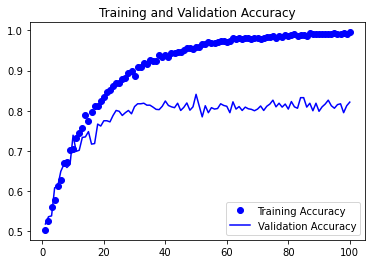

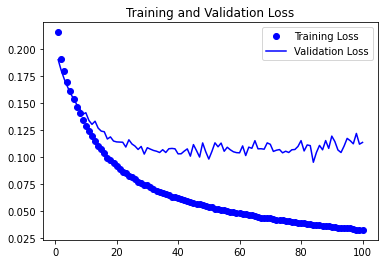

<Figure size 432x288 with 0 Axes>

In [19]:
epochs = range(1, len(accuracy) + 1)

# Accuracy Plots
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

# Generate acc loss percentages
#, valid_precision, valid_recall, valid_f1, valid_mcc
test_loss, test_acc = VGG16_best.evaluate_generator(test_generator, steps=len(test_generator))
print("\nvalid_acc: ", test_acc)
print("valid_loss: ", test_loss)
#print("valid_precision: ", valid_precision)
#print("valid_recall: ", valid_recall)
#print("valid_f1: ", valid_f1)
#print("valid_mcc: ", valid_mcc)

In [20]:
# Classification metric matrix: precision, recall, f1-score, support
test_preds = np.round(VGG16_best.predict_generator(test_generator),0)
test_trues = test_generator.classes

# Label data
classes = list(test_generator.class_indices.keys())

print(classification_report(test_trues, test_preds, target_names=classes))

              precision    recall  f1-score   support

        0-CN       0.66      0.94      0.77       142
        1-AD       0.90      0.51      0.65       142

    accuracy                           0.73       284
   macro avg       0.78      0.73      0.71       284
weighted avg       0.78      0.73      0.71       284



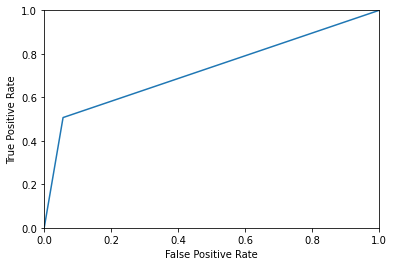

Area Under ROC: 0.7253521126760563


In [21]:
false_pos_rt, true_pos_rt, _ = roc_curve ( test_trues , test_preds)

plt.plot(false_pos_rt,true_pos_rt) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()

print("Area Under ROC: {}".format(roc_auc_score(test_trues,test_preds)))

Confusion Matrix


<AxesSubplot:>

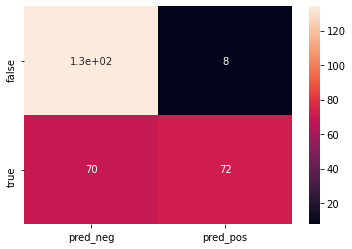

In [22]:
conf_mat = confusion_matrix(test_trues, test_preds)

print("Confusion Matrix")
sns.heatmap(conf_mat, annot=True, xticklabels=["pred_neg", "pred_pos"], yticklabels=["false", "true"])